# Bar Path Tracker:

## Imports

In [1]:
import numpy as np
import os
import sys
import pandas
import cv2
import scipy
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

repo_path = r'C:\Users\ellio\OneDrive\Desktop\GitHub\bar_path_tracker'
video_path = r'data\example_videos\bench_example.mp4'


## Basic Utils:

In [2]:
def open_and_display_video(path:str) -> None:
    print(f"Opening {str(os.path.join(repo_path, path))}")
    
    vid = cv2.VideoCapture(os.path.join(repo_path, path))
    if (vid.isOpened()== False): 
        print("Error opening video stream or file")
    else:
        print(f"Playing video at {path}. Hit 'q' to quit.")
    
    while(vid.isOpened()):
        # Capture frame-by-frame
        ret, frame = vid.read()
        
        if ret == True:
            cv2.imshow('Video', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else: 
            break
    # When everything done, release the video capture object
    vid.release()
    # Closes all the frames
    cv2.destroyAllWindows()
    
def get_tracker():

    tracker = cv2.TrackerCSRT_create()
    tracker_type = "CSRT"

    return tracker, tracker_type

#open_and_display_video(r'data\example_videos\squat_example.mp4')
#tracker, tracker_type = get_tracker()

In [3]:
def get_starting_bbox(video_path, plate_size):

    cv2.destroyAllWindows()
    video = cv2.VideoCapture(os.path.join(repo_path, video_path))
    ret, frame = video.read()
    if not ret:
        print('cannot read the video')

    frame_height, frame_width = frame.shape[:2]

    frame_height = 1500
    frame_width = 1500

    # Resize the video for a more convenient view
    frame = cv2.resize(frame, [frame_width//2, frame_height//2])

    # Select the bounding box in the first frame
    bbox = cv2.selectROI(frame, False)
    cv2.destroyAllWindows()
    start_bbox_centre = (
        int(bbox[0] + bbox[2]/2),
        int(bbox[1] + bbox[3]/2)
    )

    meters_per_pixel_y = plate_size/bbox[3]
    meters_per_pixel_x = plate_size/bbox[3]

    return bbox, start_bbox_centre, meters_per_pixel_x, meters_per_pixel_y

#starting_bbox, starting_bbox_centre, meters_per_pixel_x, meters_per_pixel_y = get_starting_bbox(r'data\example_videos\bench_example.mp4', 0.43)

In [4]:
def track_bar_path(video_path, starting_bbox, starting_bbox_centre, meters_per_pixel_x, meters_per_pixel_y, verbose=False):

    line_colour = (255,255,255)
    box_colour = (255,255,255)
    frame_height = 1500
    frame_width = 1500
    bar_path = {}
    previous_centre = starting_bbox_centre

    tracker, tracker_type = get_tracker()

    # load video:
    cv2.destroyAllWindows()
    video = cv2.VideoCapture(os.path.join(repo_path, video_path))
    time = video.get(cv2.CAP_PROP_FPS)/1000
    ret, frame = video.read()
    if not ret:
        print('cannot read the video')

    # Resize the video for a more convenient view
    frame = cv2.resize(frame, [frame_width//2, frame_height//2])
    mask = np.zeros_like(frame)

    # Initialize video writer to save the results
    output = cv2.VideoWriter(f'{tracker_type}.mp4', 
                            cv2.VideoWriter_fourcc(*'XVID'), 60.0, 
                            (frame_width//2, frame_height//2), True)

    # Select the bounding box in the first frame
    ret = tracker.init(frame, starting_bbox)

    # Start tracking
    while True:
        ret, frame = video.read()
        time = video.get(cv2.CAP_PROP_POS_MSEC)/1000
        if not ret:
            break

        frame = cv2.resize(frame, [frame_width//2, frame_height//2])
        timer = cv2.getTickCount()
        ret, bbox = tracker.update(frame)
        fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

        if ret:
            top_left = (int(bbox[0]), int(bbox[1])) # top left
            bottom_right = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])) # bottom right
            centre = [int(bbox[0] + bbox[2]/2), int(bbox[1] + bbox[3]/2)]

            mask = cv2.line(mask, previous_centre, centre, line_colour, 2)
            frame = cv2.rectangle(frame, top_left, bottom_right, box_colour, 2, 1)

            centre_x = centre[0] - starting_bbox_centre[0]
            centre_y = starting_bbox_centre[1] - centre[1]

            bar_path[round(time,3)] = {
                'centre_in_meters': [centre_x * meters_per_pixel_x, centre_y * meters_per_pixel_y],
                'centre_in_pixels': [centre[0], centre[1]],
                'bounding-box': list(bbox)
                }


        else:
            cv2.putText(frame, "Tracking failure detected", (100,80), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.75,(255,255,255),2)
            
        # Show stats:
        
        if verbose:

            cv2.putText(frame, tracker_type + " Tracker", (0,20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255),2)
            cv2.putText(frame, "FPS: " + str(int(fps)), (0,50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255),2)
            cv2.putText(frame, "Time: " + str(round(time,1)) + "s", (0,80), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255),2) 
            cv2.imshow("Tracking", full_frame)
    
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        full_frame = cv2.add(frame, mask)
        output.write(full_frame)
        previous_centre = centre
            
    video.release()
    output.release()
    cv2.destroyAllWindows()

    return bar_path

#bar_path = track_bar_path(r'data\example_videos\bench_example.mp4', starting_bbox, starting_bbox_centre, meters_per_pixel_x, meters_per_pixel_y)       

In [5]:
def differentiate(quantity, time, smooth_quanity=False, smoothing_poly_order=5):
    
    if smooth_quanity:
        quantity = savgol_filter(quantity, 51, smoothing_poly_order)
    
    d_quantity = quantity[1:] - quantity[:-1]
    d_time = time[1:] - time[:-1]

    quantity_time = d_quantity/d_time 
    quantity_time = np.append(quantity_time, quantity_time[-1])

    return d_quantity/d_time


def get_stats(bar_path, weight, verbose=False):
    times = np.array(list(bar_path.keys()))
    centres = np.array([entry['centre_in_meters'] for entry in bar_path.values()])

    x_distances = centres[:,0]
    y_distances = centres[:,1]

    total_distance = (y_distances**2 + x_distances**2)**0.5

    #speeds = differentiate(total_distance, times, smooth_quanity=True)

    speeds = np.gradient(total_distance, times)
    accelerations = np.gradient(speeds, times)

    #y_speeds = differentiate(y_distances, times, smooth_quanity=True)

    #speeds = speeds * np.sign(y_speeds)

    #accelerations = differentiate(speeds, times[1:], smooth_quanity=True)

    #speeds = np.pad(speeds, (0,len(times)-len(speeds)), mode='constant', constant_values = speeds[-1])
    #accelerations = np.pad(accelerations, (0,len(times)-len(accelerations)), mode='constant', constant_values = accelerations[-1])
    
    stats = {}
    for i, t in enumerate(times):
        stats[t] = {
            'x_distance': x_distances[i],
            'y_distance': y_distances[i],
            'speeds': speeds[i],
            'accelerations': accelerations[i]
            }

    if verbose:
        f, axs = plt.subplots(1,4, figsize = (17,3))

        axs[0].plot(times, y_distances, c = "b", linewidth  = 2)
        axs[0].set_title("Vertical range")
        axs[0].set_xlabel("Time")
        #axs[0].set_xticks([])
        #axs[0].set_yticks([])

        axs[1].plot(times, x_distances, c = "b", linewidth  = 2)
        axs[1].set_title("Horizontal range")
        axs[1].set_xlabel("Time")
        #axs[1].set_xticks([])
        #axs[1].set_yticks([])

        axs[2].plot(times, speeds, c = "r", linewidth  = 2)
        axs[2].set_title("Speed (m/s)")
        axs[2].set_xlabel("Time")
        #axs[2].set_xticks([])
        #axs[2].set_yticks([])

        axs[3].plot(times, accelerations*weight, c = "g", linewidth  = 1)
        axs[3].set_title("Force (N)")
        axs[3].set_xlabel("Time")
        #axs[3].set_xticks([])
        #axs[3].set_yticks([])    
    
    return stats

    
#s = get_stats(bar_path, 70, True)

In [6]:
def get_turning_points(times, displacements, verbose=False):

    norm_v_displacements = (displacements - displacements.min())/(displacements.max() - displacements.min())
    v_smoothed = savgol_filter(norm_v_displacements, 51, 5)

    peaks = scipy.signal.find_peaks(v_smoothed, height=0.5)
    troughs = scipy.signal.find_peaks(1 - v_smoothed, height=0.5)

    num_peaks = len(peaks[0])
    num_troughs = len(troughs[0])
    #num_reps = max(num_peaks, num_troughs)

    heights = np.array([])
    heights = np.append(heights, -1*troughs[1]['peak_heights'])
    heights = np.append(heights, peaks[1]['peak_heights'])

    turning_point_times = np.array([])
    turning_point_times = np.append(turning_point_times, troughs[0])
    turning_point_times = np.append(turning_point_times, peaks[0])

    x = sorted(zip(turning_point_times, heights))


    turning_points = {}#{0:x[0][1]}

    prev_sign = not x[0][1] < 0

    for i, (t, h) in enumerate(x):

        sign = h < 0
        if sign != prev_sign or i ==0 :
            turning_points[int(t)] = h
            prev_h = h
        else:
            if sign:
                prev_h = min(h, prev_h)
            else:
                prev_h = max(h, prev_h)
        
        prev_sign = sign

    extreme_times = list(turning_points.keys())
    extreme_heights = list(turning_points.values())

    num_reps = int(len(turning_points)/2)

    if verbose:

        plt.scatter(times, displacements)
        plt.scatter(times[extreme_times], displacements[extreme_times])
        print(f"{num_reps} reps detected.")
    
    return turning_points
    

#times = np.array(list(s.keys()))
#y_displacements = np.array([entry['y_distance'] for entry in s.values()])
#x_displacements = np.array([entry['x_distance'] for entry in s.values()])
#turning_points = get_turning_points(times, y_displacements, True)

In [7]:
def get_reps(turning_point_times, times):
    
    reps = {}

    for i in range(len(turning_point_times)):
        if i %2 == 0 and i+2 < len(turning_point_times):
            reps[int(i/2)+1] = {
                'frame_inds':[turning_point_times[i], turning_point_times[i+2]],
                'times': [times[turning_point_times[i]], times[turning_point_times[i+2]]]
                }
            
    last_rep = max(list(reps.keys()))
    reps[last_rep]['times'][1] = times[-1]
        
    return reps

#turning_point_times = list(turning_points.keys())
#get_reps(turning_point_times, times)


In [8]:
def plot_reps(x_displacements, y_displacements, turning_points, speeds):


    f, axs = plt.subplots(1, len(turning_points)-1, figsize = (12,4))

    extreme_times = list(turning_points.keys())

    count = 0

    for i in range(len(turning_points)-1):

        if np.mean(speeds[extreme_times[i]:extreme_times[i+1]]) < 0:
            c = "green"
            title = "Eccentric"
        else:
            c = "red"
            title = "Concentric"

        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].plot(
            x_displacements[extreme_times[i]: extreme_times[i+1]],
            y_displacements[extreme_times[i]: extreme_times[i+1]],
            c = c
        )
        axs[i].set_title(title)
    
#speeds = np.array([entry['speeds'] for entry in s.values()])
#plot_reps(x_displacements, y_displacements, turning_points, speeds)

In [9]:
def show_video_with_stats(video_path, bar_path, stats, reps):

    line_colour = (255,255,255)
    frame_height = 1500
    frame_width = 1500
    tracker_type = "CSRT"


    # load video:
    cv2.destroyAllWindows()
    video = cv2.VideoCapture(os.path.join(repo_path, video_path))
    time = video.get(cv2.CAP_PROP_FPS)/1000
    ret, frame = video.read()
    if not ret:
        print('cannot read the video')

    # Resize the video for a more convinient view
    frame = cv2.resize(frame, [frame_width//2, frame_height//2])
    mask = np.zeros_like(frame)

    # Initialize video writer to save the results
    output = cv2.VideoWriter(f'{tracker_type}_with_stats.mp4', 
                            cv2.VideoWriter_fourcc(*'XVID'), 60.0, 
                            (frame_width//2, frame_height//2), True)
    
    previous_centre = None

    # Start tracking
    while True:
        ret, frame = video.read()
        time = round(video.get(cv2.CAP_PROP_POS_MSEC)/1000,3)

        if not ret:
            break
        rep_number = [n for (n,v) in reps.items() if (time <= v['times'][1] and time >= v['times'][0])]
        if rep_number:
            rep_number = rep_number[0]
        else:
            rep_number = 0

        frame = cv2.resize(frame, [frame_width//2, frame_height//2])
        timer = cv2.getTickCount()
        fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

        if time in list(bar_path.keys()):
            centre = bar_path[round(time,3)]['centre_in_pixels']
            if previous_centre is not None:
                mask = cv2.line(mask, previous_centre, centre, line_colour, 2)
            previous_centre = centre
            speed = stats[time]['speeds']
            acceleration = stats[time]['accelerations']
            cv2.putText(frame, "Speed: " + str(round(speed,1)) + "m/s", (0,100), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255),2)
            cv2.putText(frame, "Acceleration: " + str(round(acceleration,1)) + "m/s^2", (0,120), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255),2)
            cv2.putText(frame, "Rep Number: " + str(int(rep_number)), (0,140), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255),2)

        # Show stats:
        cv2.putText(frame, tracker_type + " Tracker", (0,20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255),2)
        cv2.putText(frame, "FPS: " + str(int(fps)), (0,50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255),2)
        cv2.putText(frame, "Time: " + str(round(time,1)) + "s", (0,80), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255),2)

        full_frame = cv2.add(frame, mask)
        cv2.imshow("Tracking", full_frame)
        output.write(full_frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    video.release()
    output.release()
    cv2.destroyAllWindows()


#show_video_with_stats(video_path, bar_path, stats, reps)
#open_and_display_video('CSRT_with_stats.mp4')

Opening C:\Users\ellio\OneDrive\Desktop\GitHub\bar_path_tracker\data\example_videos\josh_deadlift.mp4
Playing video at data\example_videos\josh_deadlift.mp4. Hit 'q' to quit.


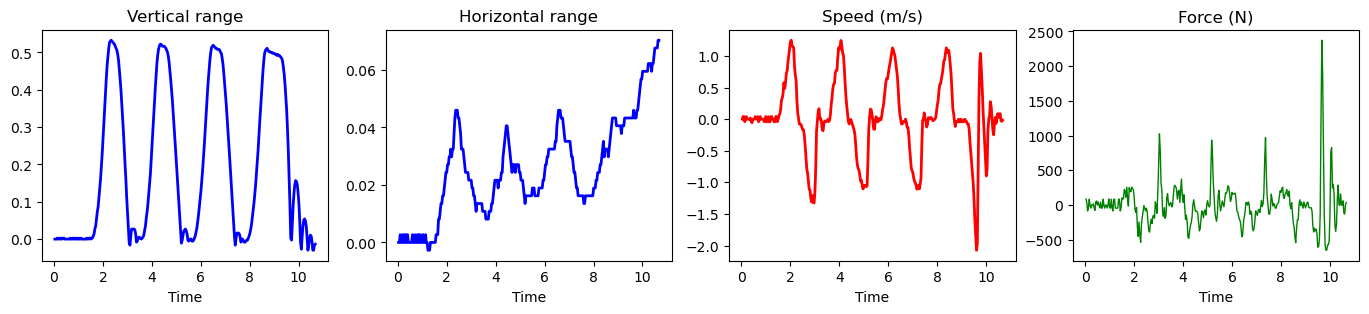

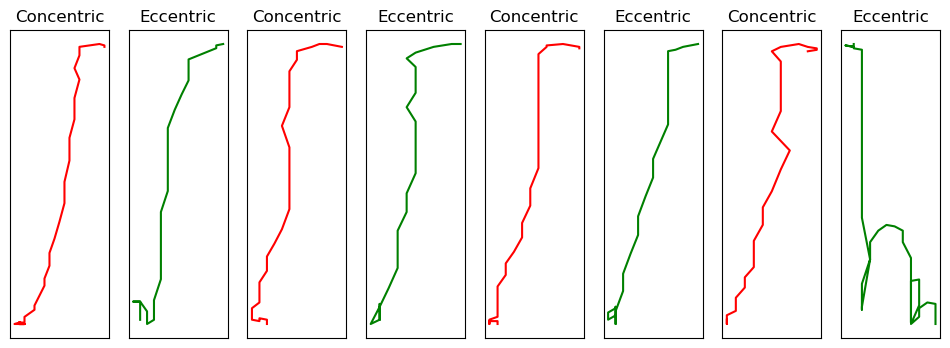

In [10]:
video_path = r'data\example_videos\josh_deadlift.mp4'

open_and_display_video(video_path)

tracker, tracker_type = get_tracker()
starting_bbox, starting_bbox_centre, meters_per_pixel_x, meters_per_pixel_y = get_starting_bbox(video_path, plate_size=0.43)
bar_path = track_bar_path(video_path, starting_bbox, starting_bbox_centre, meters_per_pixel_x, meters_per_pixel_y, False)

weight = 70
stats = get_stats(bar_path, weight, True)
times = np.array(list(stats.keys()))
y_displacements = np.array([entry['y_distance'] for entry in stats.values()])
x_displacements = np.array([entry['x_distance'] for entry in stats.values()])
speeds = np.array([entry['speeds'] for entry in stats.values()])
accelerations = np.array([entry['accelerations'] for entry in stats.values()])

turning_points = get_turning_points(times, y_displacements, False)
turning_point_times = np.array(list(turning_points.keys()))
reps = get_reps(turning_point_times, times)

plot_reps(x_displacements, y_displacements, turning_points, speeds)
show_video_with_stats(video_path, bar_path, stats, reps)

In [11]:
#show_video_with_stats(video_path, bar_path, stats, reps)
open_and_display_video('src\CSRT_with_stats.mp4')


Opening C:\Users\ellio\OneDrive\Desktop\GitHub\bar_path_tracker\src\CSRT_with_stats.mp4
Playing video at src\CSRT_with_stats.mp4. Hit 'q' to quit.


In [12]:
reps

{1: {'frame_inds': [15, 101], 'times': [0.534, 3.402]},
 2: {'frame_inds': [101, 164], 'times': [3.402, 5.503]},
 3: {'frame_inds': [164, 230], 'times': [5.503, 7.704]},
 4: {'frame_inds': [230, 317], 'times': [7.704, 10.672]}}

In [13]:
def fast_track_bar_path(video_path, starting_bbox, starting_bbox_centre, meters_per_pixel):

    frame_height = 2000
    frame_width = 2000
    bar_path = {}
    previous_centre = starting_bbox_centre

    # load video:
    cv2.destroyAllWindows()
    video = cv2.VideoCapture(os.path.join(repo_path, video_path))
    time = video.get(cv2.CAP_PROP_FPS)/1000
    ret, frame = video.read()
    if not ret:
        print('cannot read the video')

    # Resize the video for a more convenient view
    frame = cv2.resize(frame, [frame_width//2, frame_height//2])

    # Select the bounding box in the first frame
    ret = tracker.init(frame, starting_bbox)

    # Start tracking
    while True:

        ret, frame = video.read()
        time = video.get(cv2.CAP_PROP_POS_MSEC)/1000
        if not ret:
            break

        frame = cv2.resize(frame, [frame_width//2, frame_height//2])
        ret, bbox = tracker.update(frame)

        if ret:

            centre = [int(bbox[0] + bbox[2]/2), int(bbox[1] + bbox[3]/2)]
            centre_x = centre[0] - starting_bbox_centre[0]
            centre_y = starting_bbox_centre[1] - centre[1]

            bar_path[round(time,3)] = {
                'centre_in_meters': [centre_x * meters_per_pixel, centre_y * meters_per_pixel],
                'centre_in_pixels': [centre_x, centre_y],
                'bounding-box': list(bbox)
                }

    cv2.destroyAllWindows()

    return bar_path

#bar_path = fast_track_bar_path(r'data\example_videos\bench_example.mp4', starting_bbox, starting_bbox_centre, meters_per_pixel)       

In [14]:
def get_rep_stats(x_displacements, y_displacements, turning_points, speeds, forces):

    extreme_times = list(turning_points.keys())
    rep_stats = {}

    rep_counter = 1

    for i in range(len(turning_points)-1):

        if np.mean(speeds[extreme_times[i]:extreme_times[i+1]]) < 0:
            pass
        else:
            average_rep_speed = np.mean(speeds[extreme_times[i]:extreme_times[i+1]])
            max_rep_speed = np.max(speeds[extreme_times[i]:extreme_times[i+1]])
            rep_range_of_motion = np.max(y_displacements[extreme_times[i]:extreme_times[i+1]]) - np.min(y_displacements[extreme_times[i]:extreme_times[i+1]])
            average_rep_force = np.max(forces[extreme_times[i]:extreme_times[i+1]])
            rep_stats[rep_counter] = {
                'average_speed (m/s)': np.round(average_rep_speed,3), 
                'Max speed (m/s)': np.round(max_rep_speed, 3),
                'rep_range_of_motion (m)': np.round(rep_range_of_motion,3),
                'max_force (N)': average_rep_force}
            rep_counter += 1

    return rep_stats

rep_stats = get_rep_stats(x_displacements, y_displacements, turning_points, speeds, accelerations)

for (k, v) in rep_stats.items():
    print(f"Rep {k}: {v}")
    

Rep 1: {'average_speed (m/s)': 0.278, 'Max speed (m/s)': 1.25, 'rep_range_of_motion (m)': 0.533, 'max_force (N)': 3.6922800871867487}
Rep 2: {'average_speed (m/s)': 0.471, 'Max speed (m/s)': 1.246, 'rep_range_of_motion (m)': 0.527, 'max_force (N)': 5.338166395019321}
Rep 3: {'average_speed (m/s)': 0.437, 'Max speed (m/s)': 1.128, 'rep_range_of_motion (m)': 0.525, 'max_force (N)': 3.9620898277318246}
Rep 4: {'average_speed (m/s)': 0.371, 'Max speed (m/s)': 1.13, 'rep_range_of_motion (m)': 0.519, 'max_force (N)': 3.6915648305926867}


## check rep caclulations so theyre getting the right part
## angle of bar for speed?